In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import csv
import json

## I. Main results: Original dataset, uniform logging policy, alpha experimentation with UCB

Load original bandit dataset ("data.tsv"):

In [2]:
data = []
with open('data.tsv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for row in reader:
        data.append(row[:-1])
        
data = np.asarray(data).astype(int)

Define LinUCB class for running simulations. See comments.

In [3]:
class LinUCB(object):

    ## Initialize LinUCB simulator
    # K: number of arms
    # d: number of dimensions in context vector
    def __init__(self, K, d):
        self.K = K
        self.d = d
        return None
    
    ## Run simulation
    # data: numpy array of size N x (2 + d), with N = number of observations 
    # alpha_sched: numpy array of size N containing the value of hyperparameter alpha used at each step
    ## Returns:
    # ctr_history: array of click-through-rate (CTR) history over time
    def run(self, data, alpha_sched):
        
        # Initialize list of A matrices, one per arm
        # Initialize list of b vectors, one per arm
        # (See Li et al 2012 for definitions of these variables)
        A = [np.eye(self.d) for arm in range(self.K)]
        b = [np.zeros([self.d, 1]) for arm in range(self.K)]
        
        # Upper confidence bound for each arm
        ucb = np.zeros([self.d, 1])
        
        N = data.shape[0]
        count = 0
        cum_reward = 0

        # Pick a random arm initially
        k = np.random.randint(0, 9)

        ctr_history = []
        
        for i in range(N):
            # Get context vector
            x = np.expand_dims(data[i,2:], axis=1)

            # Compute the expected payoff and updated UCB for each arm
            for k in range(self.K):
                theta = np.linalg.inv(A[k]).dot(b[k])
                ucb[k] = theta.T.dot(x) + alpha_sched[i] * np.sqrt(x.T.dot(np.linalg.inv(A[k])).dot(x))
            # Pick arm with highest UCB
            max_k = np.argmax(ucb)
            
            # Get logged action and reward
            a = data[i,0] - 1
            r = data[i,1]
            
            # Update CTR and update A, b of chosen arm IF the LinUCB choice matches up with observed arm
            if max_k == a:  
                count += 1
                cum_reward += r
                A[max_k] += x.dot(x.T)
                b[max_k] += r * x
            
            if count == 0:
                ctr_history.append(0)
            else:
                ctr_history.append(cum_reward/count)
        
        return ctr_history

Figure 1a: CTRs for varying values of alpha held constant over time.

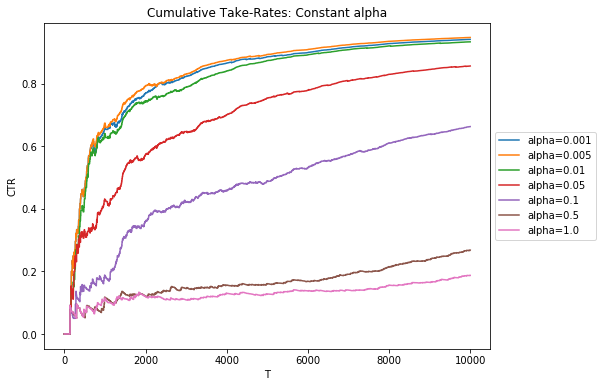

In [4]:
ucbRunner = LinUCB(10, 100)

alpha_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]

final_ctrs = {}

plt.figure(figsize=(8,6))

for alpha_val in alpha_vals:

    alpha_sched = np.ones([data.shape[0]]) * alpha_val

    ctr_history = ucbRunner.run(data, alpha_sched)
    
    final_ctrs[alpha_val] = ctr_history[-1]
    
    plt.plot(ctr_history, label="alpha={}".format(alpha_val))
    
plt.title("Cumulative Take-Rates: Constant alpha")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 1b: CTRs for varying rates of alpha decay over time.

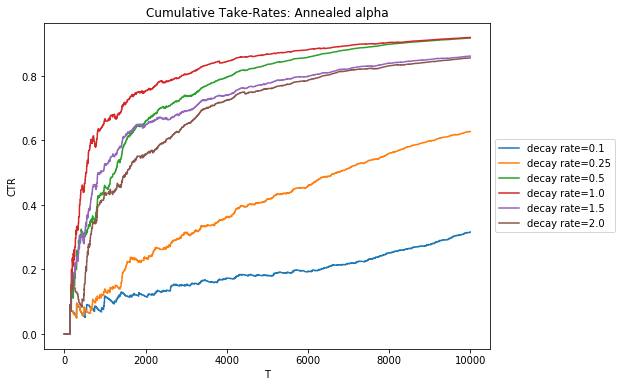

In [5]:
decay_rates = [0.1, 0.25, 0.5, 1., 1.5, 2.]

final_ctrs_with_decay = {}

plt.figure(figsize=(8,6))

for rate in decay_rates:

    alpha_sched = 1/((np.arange(data.shape[0]) + 1)**rate)

    ctr_history = ucbRunner.run(data, alpha_sched)
    
    final_ctrs_with_decay[rate] = ctr_history[-1]
    
    plt.plot(ctr_history, label="decay rate={}".format(rate))
    
plt.title("Cumulative Take-Rates: Annealed alpha")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 2: CTRs for hybrid alpha schedules (first decaying, then fixed at a minimum level)

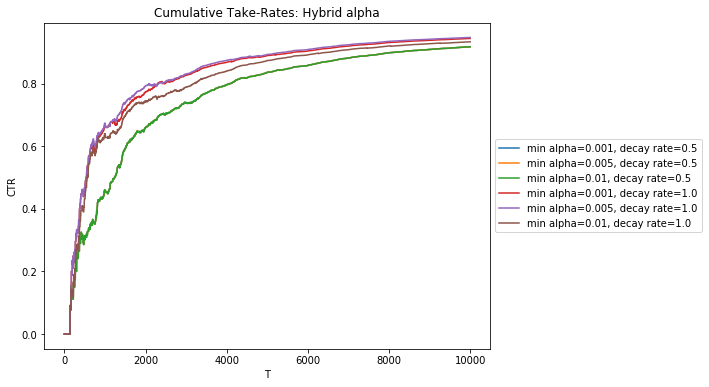

In [6]:
decay_rates = [0.5, 1.]
min_alphas = [0.001, 0.005, 0.01]

final_ctrs_hybrid = {}

plt.figure(figsize=(8,6))

for rate in decay_rates:
    final_ctrs_hybrid[rate] = {}
    
    for min_alpha in min_alphas:
        alpha_sched = 1/((np.arange(data.shape[0]) + 1)**rate)

        alpha_sched = np.clip(alpha_sched, min_alpha, 1.)

        ctr_history = ucbRunner.run(data, alpha_sched)

        final_ctrs_hybrid[rate][min_alpha] = ctr_history[-1]

        plt.plot(ctr_history, label="min alpha={}, decay rate={}".format(min_alpha, rate))
    
plt.title("Cumulative Take-Rates: Hybrid alpha")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [9]:
uniform_results = {
    "constant_alpha": final_ctrs, 
    "annealed_alpha": final_ctrs_with_decay,
    "hybrid_alpha": final_ctrs_hybrid
}

with open('uniform_results.json', 'w') as fp:
    json.dump(uniform_results, fp)

## II. Other results: Extra dataset (non-uniform logging policy)

Load optional classification dataset ("classification.tsv"):

In [12]:
data_all = []
with open('classification.tsv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for row in reader:
        data_all.append([row[0]] + row[2:])
        
data_all = np.asarray(data_all).astype(int)

Convert classification dataset to new (non-uniform) bandit dataset:

In [13]:
data_opt = np.zeros_like(data)

N = data_all.shape[0]
arms = np.unique(data_all[:,0])

## Non-uniform logging policy
p_arms = np.array([0.19, 0.19, 0.19, 0.19, 0.19, 0.01, 0.01, 0.01, 0.01, 0.01])

for i in range(N):
    ## Pick arm according to non-uniform logging policy
    arm = np.random.choice(arms, size=1, replace=False, p=p_arms)[0]
    data_opt[i,0] = arm
    
    ## If chosen arm matches up with true class, reward is 1 (otherwise 0)
    if arm == data_all[i,0]:
        data_opt[i, 1] = 1
    
    ## Record feature vector
    data_opt[i,2:] = data_all[i,1:]

Record CTR results for the same hyperparameter settings as the uniform case.

In [14]:
ucbRunner = LinUCB(10, 100)

## Constant alpha
alpha_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]
final_ctrs_2 = {}
for alpha_val in alpha_vals:
    alpha_sched = np.ones([data_opt.shape[0]]) * alpha_val
    ctr_history = ucbRunner.run(data_opt, alpha_sched)    
    final_ctrs_2[alpha_val] = ctr_history[-1]

## Decaying alpha
decay_rates = [0.1, 0.25, 0.5, 1., 1.5, 2.]
final_ctrs_with_decay_2 = {}
for rate in decay_rates:
    alpha_sched = 1/((np.arange(data_opt.shape[0]) + 1)**rate)
    ctr_history = ucbRunner.run(data_opt, alpha_sched)
    final_ctrs_with_decay_2[rate] = ctr_history[-1]
    
## Hybrid alpha
decay_rates = [0.5, 1.]
min_alphas = [0.001, 0.005, 0.01]
final_ctrs_hybrid_2 = {}
for rate in decay_rates:
    final_ctrs_hybrid_2[rate] = {}
    for min_alpha in min_alphas:
        alpha_sched = 1/((np.arange(data_opt.shape[0]) + 1)**rate)
        alpha_sched = np.clip(alpha_sched, min_alpha, 1.)
        ctr_history = ucbRunner.run(data_opt, alpha_sched)
        final_ctrs_hybrid_2[rate][min_alpha] = ctr_history[-1]
        
nonuniform_results = {
    "constant_alpha": final_ctrs_2, 
    "annealed_alpha": final_ctrs_with_decay_2,
    "hybrid_alpha": final_ctrs_hybrid_2
}

with open('nonuniform_results.json', 'w') as fp:
    json.dump(nonuniform_results, fp)

In [45]:
class LinUCB(object):

    ## Initialize LinUCB simulator
    # K: number of arms
    # d: number of dimensions in context vector
    def __init__(self, K, d):
        self.K = K
        self.d = d
        return None
    
    ## Run simulation
    # data: numpy array of size N x (2 + d), with N = number of observations 
    # alpha_sched: numpy array of size N containing the value of hyperparameter alpha used at each step
    ## Returns:
    # ctr_history: array of click-through-rate (CTR) history over time
    def run(self, data, alpha_sched, logging_probs):
        
        # Initialize list of A matrices, one per arm
        # Initialize list of b vectors, one per arm
        # (See Li et al 2012 for definitions of these variables)
        A = [np.eye(self.d) for arm in range(self.K)]
        b = [np.zeros([self.d, 1]) for arm in range(self.K)]
        
        # Upper confidence bound for each arm
        ucb = np.zeros([self.d, 1])
        
        N = data.shape[0]
        count = 0
        cum_reward = 0

        # Pick a random arm initially
        k = np.random.randint(0, 9)

        ctr_history = []
        arm_history = []
        
        # Normalization constant for rejection sampling
        M = 1/(np.min(logging_probs)*self.K)
        
        for i in range(N):
            # Get context vector
            a = data[i,0] - 1
            p = logging_probs[a]
            
            ## Sample from uniform[0,1] distribution.....
            ## Accept logged event with probability inversely proportional to its true probability 
            if np.random.uniform() > (1./self.K)/(M*p):
                continue
            arm_history.append(a)
            x = np.expand_dims(data[i,2:], axis=1)

            # Compute the expected payoff and updated UCB for each arm
            for k in range(self.K):
                theta = np.linalg.inv(A[k]).dot(b[k])
                ucb[k] = theta.T.dot(x) + alpha_sched[i] * np.sqrt(x.T.dot(np.linalg.inv(A[k])).dot(x))
            # Pick arm with highest UCB
            max_k = np.argmax(ucb)
            
            # Get logged action and reward
            r = data[i,1]
            
            # Update CTR and update A, b of chosen arm IF the LinUCB choice matches up with observed arm
            if max_k == a:  
                count += 1
                cum_reward += r
                A[max_k] += x.dot(x.T)
                b[max_k] += r * x
            
            if count == 0:
                ctr_history.append(0)
            else:
                ctr_history.append(cum_reward/count)
        
        return ctr_history, arm_history

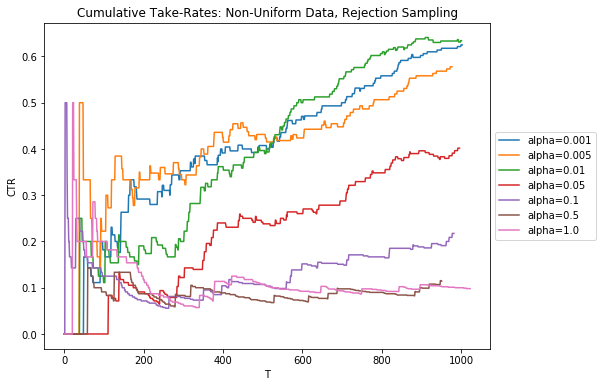

In [46]:
ucbRunner = LinUCB(10, 100)

alpha_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]

final_ctrs_3 = {}

plt.figure(figsize=(8,6))

for alpha_val in alpha_vals:

    alpha_sched = np.ones([data_opt.shape[0]]) * alpha_val

    ctr_history, arm_history = ucbRunner.run(data_opt, alpha_sched, p_arms)
    
    final_ctrs_3[alpha_val] = ctr_history[-1]
    
    plt.plot(ctr_history, label="alpha={}".format(alpha_val))
    
plt.title("Cumulative Take-Rates: Non-Uniform Data, Rejection Sampling")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

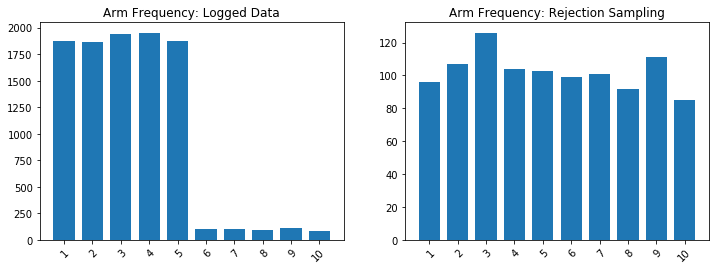

In [87]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
bins = np.unique(data_opt[:,0])
bars = np.histogram(data_opt[:,0])[0]
ax1.bar(bins,bars,width=.75)
ax1.set_xticks(bins)
ax1.set_xticklabels(bins,rotation=45, rotation_mode="anchor", ha="right")
ax1.set_title("Arm Frequency: Logged Data")

ax2 = plt.subplot(122)
bins = np.unique(arm_history)
bars = np.histogram(arm_history)[0]
ax2.bar(bins,bars,width=.75)
ax2.set_xticks(bins)
ax2.set_xticklabels([b + 1 for b in bins],rotation=45, rotation_mode="anchor", ha="right")
ax2.set_title("Arm Frequency: Rejection Sampling")
plt.show()